In [159]:
import numpy as np
from Jcb import Jcb, calc_basis_matrix
from scipy.linalg import block_diag
from tqdm import tqdm
from scipy.optimize import minimize
from plot_fun import subplot_results

In [250]:
N = 4
Ky = 2
Kx = [[2], [2]] # step
Kb = [[3], [3]] # polynomial ## --- Tie Kb and Ky

In [251]:
def calc_I_theta(Kx, Ky):
    return np.eye((len(Kx)+1)*Ky, dtype=float)
def calc_J_CH(Kx, Kb):
    J_chs = [Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(x_row, b_row)]) for x_row, b_row in zip(Kx, Kb)]
    bases = [1] + J_chs
    return block_diag(*bases)
def calc_Sigma(Kx, Ky, N, decay=0):
    In = np.eye(N)
    inputs = np.linspace(0,1,(len(Kx)+1)*Ky)
    def exp_decay(decay, x):
        return np.exp(-decay*x)

    if decay == 0:
        sigma1 = np.diag(exp_decay(decay, inputs))
    elif decay==np.inf:
        elements = np.zeros((len(Kx)+1)*Ky)
        elements[0]=1
        sigma1 = np.diag(elements)
    else:
        sigma1 = np.diag(exp_decay(decay, inputs))
    return np.kron(In, sigma1)
def Covar(Gamma, J_CH, I_theta, Sigma):
    Z = Gamma @ J_CH
    ZtZ_inv = np.linalg.inv(Z.T @ Z)
    L1 = ZtZ_inv @ Z.T
    L = np.kron(I_theta, L1)
    return L @ Sigma @ L.T
def optimality(Var, type='A'):
    if type=='A':
        return np.trace(Var)
    elif type =='D':
        return np.linalg.det(Var)

def cordex_func(N, Kx,
                I_theta, J_CH, Sigma, epochs=1_000):

    def objective(x):
        Gamma_[run, feat] = x
        Gamma = np.hstack((np.ones((N, 1)), Gamma_))
        Z = Gamma @ J_CH
        ZtZ_inv = np.linalg.inv(Z.T @ Z)
        L1 = ZtZ_inv @ Z.T
        L = np.kron(I_theta, L1)
        Covar = L @ Sigma @ L.T
        return np.trace(Covar)

    Best_des = None
    Best_obj = np.inf

    for _ in tqdm(range(epochs)):
        objective_value = np.inf
        Gamma_ = np.hstack([np.random.rand(N, k[0]) for k in Kx])

        for run in range(N):
            for feat in range(np.sum(Kx)-1):
                res = minimize(objective, Gamma_[run, feat], method='L-BFGS-B', bounds=[(-1., 1.)])
                if res.x is not None:
                    Gamma_[run, feat] = res.x
                objective_value = objective(res.x)
        if 0 <= objective_value < Best_obj:
            Best_obj = objective_value
            Best_des = Gamma_

    return Best_des, np.abs(Best_obj)

In [252]:
I_theta = calc_I_theta(Kx=Kx, Ky=Ky)
J_CH = calc_J_CH(Kx=Kx, Kb=Kb)
Sigma = calc_Sigma(Kx=Kx, Ky=Ky, N=N, decay=0)
Gamma = np.hstack([np.ones((N, 1))] + [np.random.rand(N, k[0]) for k in Kx])
Var = Covar(Gamma=Gamma, J_CH=J_CH, I_theta=I_theta, Sigma=Sigma)

In [253]:
Sigma.shape

(24, 24)

In [254]:
optimality(Var, type='D')

3.5478255554898966e+221

In [255]:
Des, Cr = cordex_func(N=N,
                      Kx=Kx,
                      I_theta=I_theta,
                      J_CH=J_CH,
                      Sigma=Sigma,
                      epochs=100)
Cr

100%|██████████| 100/100 [00:04<00:00, 21.95it/s]


2343.6290136039047

In [256]:
Des

array([[8.61510720e-01, 1.30313338e-01, 6.86389051e-01, 2.11036634e-01],
       [7.47036246e-01, 3.98626722e-01, 6.84166328e-01, 9.06035204e-01],
       [4.31984165e-01, 1.65135473e-01, 1.16850322e-01, 9.84372554e-01],
       [3.87491731e-01, 2.87539928e-01, 1.84339762e-04, 3.00094101e-01]])

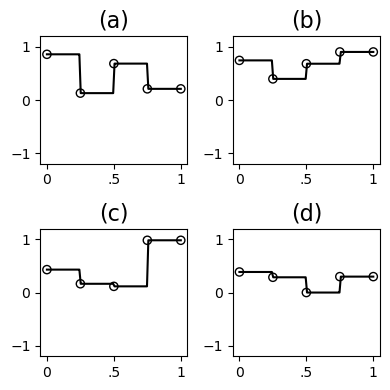

In [257]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0, 1, 100), results=Des)